# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [121]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Reading AZDIAS and CUSTOMERS dataset

In [ ]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# save as pickle for faster load times 
#azdias.to_pickle('azdias.pickle')
#customers.to_pickle('customers.pickle')

In [5]:
# load in the data from pickle
azdias = pd.read_pickle('azdias.pickle')
customers = pd.read_pickle('customers.pickle')

AZDIAS dataset:

In [ ]:
azdias.head(5)

In [ ]:
print("Azdias dataset contains of {} features and {} rows".format(azdias.shape[1], azdias.shape[0]))

In [ ]:
# Get azdias column datatypes
azdias.dtypes.value_counts()

In [ ]:
azdias.describe()

CUSTOMERS dataset:

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head(5)

In [ ]:
print("Customers dataset contains of {} features and {} rows".format(customers.shape[1], customers.shape[0]))

In [ ]:
customers.dtypes.value_counts()

In [ ]:
customers.describe()

### Data wrangling

AZDIAS dataset:

#### Drop unknown columns

The dataset `DIAS Information Levels - Attributes 2017` contains information and explanations to most features of the azdias dataset. As I want to focus on features whose meaning I know, I restrict myself on features described in the dataset.

In [6]:
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header = 1, usecols='C:D', dtype='str')
attributes_df.head(5)

,Attribute,Description
0,AGER_TYP,best-ager typology
1,ALTERSKATEGORIE_GROB,age through prename analysis
2,ANREDE_KZ,gender
3,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...
4,FINANZ_MINIMALIST,financial typology: low financial interest


In [7]:
attribute_list = attributes_df['Attribute'].tolist()
len(attribute_list)

313

In [8]:
azdias_not_in_attribute_list = list(set(azdias) - set(attribute_list))
len(azdias_not_in_attribute_list)

102

In [ ]:
azdias.drop(labels=azdias_not_in_attribute_list, axis=1, inplace=True)

In [ ]:
azdias.head(5)

In [ ]:
azdias.shape

By restricting my analysis on features from the `DIAS Information Levels - Attributes 2017` dataset, we went from initially 366 to now **264** features.

#### Handle datatypes

In [ ]:
# Convert
for column in azdias.columns:
        if azdias[column].dtype == np.int64:
            azdias[column] = azdias[column].astype(np.float64)

In [ ]:
# Print string columns
azdias.select_dtypes(['object']).head(5)

`CAMEO_DEUG_2015` should be `int64` columns. Let's have a look why they were not converted correctly.

In [ ]:
azdias[azdias['CAMEO_DEUG_2015'].str.isnumeric() == False].CAMEO_DEUG_2015.value_counts()

Seems like missing values in this columns are handled not consistendly. Let's remove these "X"-values by the value from `DIAS Information Levels - Attributes 2017.xlsx`.

In [ ]:
azdias.loc[azdias['CAMEO_DEUG_2015'] == 'X','CAMEO_DEUG_2015'] = np.nan

In [ ]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float64').astype('Int64')

#### Handle missing data

First, I want to check the distribution of missing values for our population.

In [ ]:
azdias.isnull().sum().sort_values(ascending=False)[:100] \
    .plot(kind="bar", figsize=(16,8), title='Top 100 most missing columns', xlabel="Column");

For some columns, the dataset from `DIAS Information Levels - Attributes 2017.xlsx` provides properties to handle missing values.

In [2]:
# Load Excel and filter for missing values
attribute2value = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1, usecols='B:E', dtype='str')
# Account for grouped rows
attribute2value = attribute2value.fillna(method='ffill')
# Print head
attribute2value.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [3]:
attribute2value_unknowns = attribute2value[attribute2value["Meaning"].isin(["unknown","unknown / no main age detectable", "no transactions known", "no transaction known", "Universal", "no Online-transactions within the last 12 months","middle mobility"])]
attribute2value_unknowns.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [4]:
unknowns_map = {}
for _, row in attribute2value_unknowns.iterrows():
    key = row["Attribute"]
    # Set first value as unknown
    unknowns_map[key] = int(row["Value"].split(", ")[0])

# Manually add missing codes from remaining columns
unknowns_map["ALTERSKATEGORIE_FEIN"] = -1
unknowns_map["CAMEO_INTL_2015"] = -1
unknowns_map["CAMEO_DEUG_2015"] = -1
unknowns_map["CAMEO_DEU_2015"] = 'XX'
unknowns_map["GEBURTSJAHR"] = -1
unknowns_map["CAMEO_INTL_2015"] = -1
unknowns_map["KBA13_CCM_1401_2500"] = -1
unknowns_map["KBA13_BAUMAX"] = -1
unknowns_map["KBA13_ANTG1"] =  -1
unknowns_map["KBA13_ANTG2"] =  -1
unknowns_map["KBA13_ANTG3"] =  -1
unknowns_map["KBA13_ANTG4"] =  -1
unknowns_map["ONLINE_AFFINITAET"] = 0
unknowns_map["LP_FAMILIE_GROB"] = 0
unknowns_map["LP_STATUS_GROB"] = 0
unknowns_map["PLZ8_BAUMAX"] = -1

In [ ]:
# fill nan with unknowns from above map
azdias.fillna(unknowns_map, inplace = True)

After filling unknowns using values provided by the `DIAS Attributes - Values 2017.xlsx` we see that a couple of nan-values remain. For these we impute median values.

In [ ]:
# fill remaining numeric unknowns using the median
#numeric_cols = azdias.select_dtypes(include=['number']).columns
azdias.fillna(azdias.median(), inplace = True)

After imputing these values, the dataset does not contain nan-values anymore.

In [ ]:
azdias.isnull().sum().sum()

In [ ]:
azdias.shape

In [ ]:
# saving modified azdias for further analysis
azdias.to_pickle('azdias_before_reencoding.pkl')

### Encoding categorical features

In [ ]:
# loading saved dataset 
azdias = pd.read_pickle('azdias_before_reencoding.pkl')

In [ ]:
# Print categorical features
azdias.select_dtypes(['object']).columns

CAMEO_DEU_2015:

'CAMEO_DEU_2015' contains 45 unique string values. I will convert these into a dummy matrix.

In [ ]:
# Get value counts
azdias.CAMEO_DEU_2015.value_counts()

In [ ]:
# Compute dummies and merge it to azidas
azdias = azdias.append(pd.get_dummies(azdias['CAMEO_DEU_2015'],  
                                      prefix='CAMEO_DEU_2015', drop_first=True)) \
            .drop('CAMEO_DEU_2015', axis=1)

In [ ]:
# Fill in NaNs after merge
azdias.fillna(0.0, inplace=True)

OST_WEST_KZ:

In [ ]:
# Let's first have a look at the distribution
azdias.OST_WEST_KZ.value_counts()

In [ ]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 0})
azdias.OST_WEST_KZ.value_counts()

In [ ]:
# Drop people that could be assigned to neigher OST nor WEST
azdias.dropna(subset = 'OST_WEST_KZ', inplace=True)

In [ ]:
azdias.shape

Cleaning function to re-use:

In [84]:
def clean_df(df, unknowns_map = {}, columns_to_drop = {}):
    """
    Cleans the dataframe:
    - Drop features based on azdias_not_in_attribute_list
    - Convert missing values based on unknowns_map
    - Re-encode categorical features
    
    params:
    - df (DataFrame): the Dataframe to be cleaned and preprocessed
    - unknowns_map (dict): the map containing the key-value pairs to map attribute and unknown representation
    - columns_to_drop (list): list of features to be dropped
    
    returns:
    - df_cleaned (Dataframe): to cleaned Dataframe
    """
    # drop features
    df_cleaned = df.copy()
    print('copy: {}'.format(df_cleaned.shape))
    df_cleaned = df_cleaned.drop(labels=columns_to_drop, axis=1)
    
            
    df_cleaned.loc[df_cleaned['CAMEO_DEUG_2015'] == 'X','CAMEO_DEUG_2015'] = np.nan
    df_cleaned['CAMEO_DEUG_2015'] = df_cleaned['CAMEO_DEUG_2015'].astype('float64').astype('Int64')
    
    # fill nan with unknowns from above map
    df_cleaned.fillna(unknowns_map, inplace = True)
    df_cleaned = df_cleaned.fillna(df_cleaned.median())
    
    print('fill unknowns: {}'.format(df_cleaned.shape))
    
    # Map categorical values
    df_cleaned = pd.get_dummies(df_cleaned, columns=['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', dtype = np.int64, drop_first=True)
    
    print('map categories: {}'.format(df_cleaned.shape))
    
    df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].map({'W': 1.0, 'O': -1.0})
    
    print('map ost west: {}'.format(df_cleaned.shape))
    # Fill in NaNs after merge   
    df_cleaned.fillna(0.0, inplace=True)
    
    print('fill nans after merge: {}'.format(df_cleaned.shape))
    
    # Fix datatypes
    for column in df_cleaned.columns:
        if df_cleaned[column].dtype == (np.int64 or 'Int64'):
            df_cleaned[column] = df_cleaned[column].astype(np.float64)
    df_cleaned.CAMEO_DEUG_2015 = df_cleaned.CAMEO_DEUG_2015.astype('float64')
    
    # Print new shape and datatypes
    print("Before: {}".format(df.shape))
    print("After: {} \n".format(df_cleaned.shape))
    print("Datatypes:")
    print(df_cleaned.dtypes.value_counts())
    
    return df_cleaned

CUSTOMERS dataframe:

Customers dataset contains 3 additional columns, namely 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'. They provide details to their executed purchase in the following way:

In [ ]:
customers.CUSTOMER_GROUP.value_counts()

In [ ]:
customers.PRODUCT_GROUP.value_counts()

In [ ]:
customers.ONLINE_PURCHASE.value_counts()

We won't need these columns for our analysis. Let's drop them.

In [ ]:
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [ ]:
customers_cleaned = clean_df(customers, unknowns_map, azdias_not_in_attribute_list)

In [ ]:
# Validate that there are no null values
customers_cleaned.isnull().sum().sum()

In [ ]:
customers_cleaned.head(5)

In [ ]:
# Store cleaned dataframes
#azdias.to_pickle('azdias_cleaned.pkl')
#customers_cleaned.to_pickle('customers_cleaned.pkl')

#### Scale features

In [2]:
# Load cleaned dataframes
azdias_cleaned = pd.read_pickle('azdias_cleaned.pkl')
customers_cleaned = pd.read_pickle('customers_cleaned.pkl')

In [3]:
# Initialize standard scaler
scaler = StandardScaler()

In [4]:
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

In [ ]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns)

In [ ]:
azdias_scaled.shape

In [ ]:
azdias_scaled.head(5)

In [ ]:
customers_scaled.shape

In [ ]:
# For further use in Part 1 and 2
azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [87]:
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
customers_scaled = pd.read_pickle('customers_scaled.pkl')

### 1 A: Dimensionality reduction: Principal Components

In [52]:
def principal_component_to_features(pca, comp_idx, column_names):
    """
    Returns dataframe with feature weights for a selected component.
    
    Input:
    pca - fitted PCA object
    component - PCA component of interest
    column_names - list of original feature names
    
    Output:
    df_features - sorted DataFrame with feature weigths
    """
    
    weights_array = pca.components_[comp_idx]
    df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.abs().sort_values(by='weight', ascending=False).round(2)

The cleaned dataset contains 307 different features. To reduce dimensions I perform principal component analysis (PCA) and reduce the dataset to most significant features.

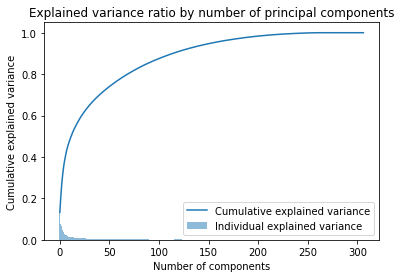

In [5]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative explained variance')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='Individual explained variance')
plt.title('Explained variance ratio by number of principal components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend(loc='best')

plt.show()

We want to construct the number of features such that most of the variance is explained by the components. As a threshold, 95% is used.

In [6]:
# Define number of components such that 95% of variance is explained
n_components = (np.cumsum(pca.explained_variance_ratio_)<0.95).sum()+1
n_components

154

Of the over 300 features in the original dataset 154 can be used to explain 95% of the variance. This means the dataset can be reduced by almost half of its features while only losing 5% of variance.

In [7]:
# Perform PCA with latent features for AZDIAS
pca = PCA(n_components=n_components)
reduced_azdias = pd.DataFrame(pca.fit_transform(azdias_scaled))
print('The variance in the data explained by the principal components after employing PCA is equal to {}'.format(pca.explained_variance_ratio_.sum()))

The variance in the data explained by the principal components after employing PCA is equal to 0.9495611444225837


In [91]:
# Perform PCA with latent features for CUSTOMERS
pca = PCA(n_components=n_components)
reduced_customers = pd.DataFrame(pca.fit_transform(customers_scaled))
print('The variance in the data explained by the principal components after employing PCA is equal to {}'.format(pca.explained_variance_ratio_.sum()))

The variance in the data explained by the principal components after employing PCA is equal to 0.9405242778810695


In [ ]:
reduced_azdias.shape

In [ ]:
reduced_customers.shape

After PCA we reduced the dataset from 304 to `154 features` while keeping around ~`95%` of variance of the original dataset.

In [ ]:
# Save reduced dataframes to pickle
reduced_azdias.to_pickle('reduced_azdias.pkl')
reduced_customers.to_pickle('reduced_customers.pkl')

**Which features do principle components stand for?**

In [49]:
# The the top 3 components explaining most of the variance
top_three_pca = pca.explained_variance_ratio_[:3]
top_three_pca

array([0.13230025, 0.07502275, 0.0652482 ])

In [53]:
print("The first three components explain {:.1%} of variance.".format(top_three_pca.sum()))

The first three components explain 27.3% of variance.


In [54]:
print("Component 1 explains {:.1%} of variance and is determined by: ".format(top_three_pca[0]))
principal_component_to_features(pca, 0, azdias_cleaned.columns).head()

Component 1 explains 13.2% of variance and is determined by: 


,weight
KBA05_KRSVAN,0.15
KBA05_KRSOBER,0.15
KBA05_KRSZUL,0.15
KBA05_KRSKLEIN,0.15
KBA05_SEG6,0.14


In [55]:
print("Component 2 explains {:.1%} of variance and is determined by: ".format(top_three_pca[1]))
principal_component_to_features(pca, 1, azdias_cleaned.columns).head()

Component 2 explains 7.5% of variance and is determined by: 


,weight
KBA13_KRSSEG_KLEIN,0.16
KBA13_AUTOQUOTE,0.15
KBA13_ALTERHALTER_60,0.13
KBA13_HALTER_50,0.13
KBA13_HALTER_55,0.13


In [56]:
print("Component 3 explains {:.1%} of variance and is determined by: ".format(top_three_pca[2]))
principal_component_to_features(pca, 2, azdias_cleaned.columns).head()

Component 3 explains 6.5% of variance and is determined by: 


,weight
PLZ8_ANTG3,0.17
MOBI_REGIO,0.16
PLZ8_ANTG4,0.16
LP_STATUS_FEIN,0.16
PLZ8_BAUMAX,0.16


### 1 B: Segmentation: Clustering via k-means

In [11]:
# load datasets
reduced_azidas = pd.read_pickle('reduced_azdias.pkl')
reduced_customers = pd.read_pickle('reduced_customers.pkl')

In [3]:
cluster_inertia = []
for n_clusters in range(1,18):
    tic = time.perf_counter()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_azidas)
    cluster_inertia.append(kmeans.inertia_)
    toc = time.perf_counter()
    print(f'k-means clustering for k={n_clusters} finished in {toc - tic:0.4f} seconds')

k-means clustering for k=1 finished in 8.3107 seconds
k-means clustering for k=2 finished in 19.1463 seconds
k-means clustering for k=3 finished in 27.6180 seconds
k-means clustering for k=4 finished in 44.1160 seconds
k-means clustering for k=5 finished in 70.5402 seconds
k-means clustering for k=6 finished in 90.4385 seconds
k-means clustering for k=7 finished in 69.2072 seconds
k-means clustering for k=8 finished in 79.6323 seconds
k-means clustering for k=9 finished in 81.5323 seconds
k-means clustering for k=10 finished in 103.9926 seconds
k-means clustering for k=11 finished in 128.1123 seconds
k-means clustering for k=12 finished in 108.9115 seconds
k-means clustering for k=13 finished in 223.7206 seconds
k-means clustering for k=14 finished in 215.2198 seconds
k-means clustering for k=15 finished in 254.9631 seconds
k-means clustering for k=16 finished in 222.3938 seconds
k-means clustering for k=17 finished in 287.3402 seconds


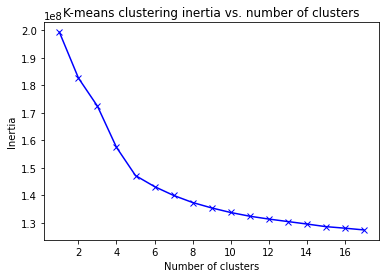

In [10]:
plt.plot(range(1,18), cluster_inertia, linestyle='-', marker='x', color='blue')
plt.title("K-means clustering inertia vs. number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia");

From above plot we see a clear elbow at `k=5` clusters. We therefore conclude to use 5 clusters for further unsupervised learning. In case that 5 clusters are too imprecise, I will use `k=11` clusters as an alternative as this is where a linear decline in inertia starts.

### 1 C: General population vs customers

**k=5**:

In [12]:
# Fit K-Means model on azdias using 5 clusters
model = KMeans(n_clusters=5, random_state=42).fit(reduced_azidas)

Let's now use the computed clusters to compare the general population to customers.

In [23]:
azdias_predictions = model.predict(reduced_azidas)
azdias_predictions

array([1, 2, 2, ..., 2, 1, 2])

In [24]:
azdias_clustered = pd.DataFrame(azdias_predictions, columns = ['cluster'])

In [25]:
customers_predictions = model.predict(reduced_customers)
customers_predictions

array([2, 1, 2, ..., 1, 1, 2])

In [26]:
customers_clustered = pd.DataFrame(customers_predictions, columns = ['cluster'])

In [40]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['cluster'].value_counts().sort_index()

In [49]:
# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

In [51]:
# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()

In [52]:
clusters.head(5)

,cluster,population_count,customers_count,population_share,customers_share
0,1,14786,933,0.018527,0.006583
1,2,341502,56136,0.427908,0.396091
2,3,395786,78216,0.495927,0.551886
3,4,34089,6013,0.042714,0.042427
4,5,11910,427,0.014923,0.003013


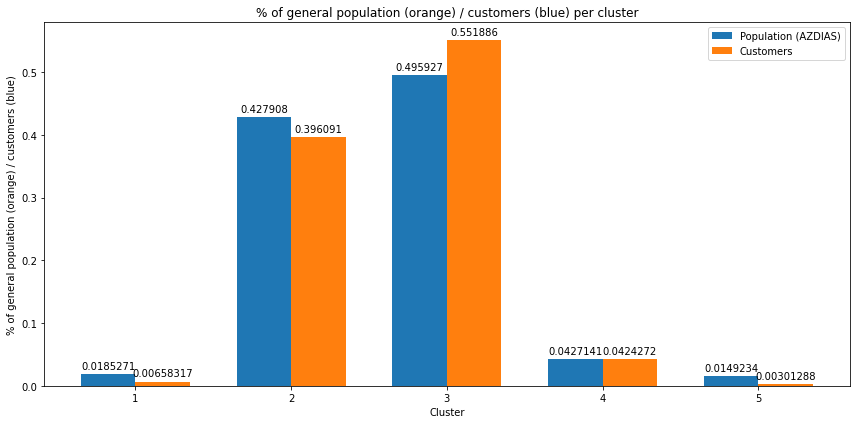

In [71]:
labels = list(clusters.cluster)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, clusters.population_share, width, label='Population (AZDIAS)')
rects2 = ax.bar(x + width/2, clusters.customers_share, width, label='Customers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of general population (orange) / customers (blue)')
ax.set_xlabel('Cluster')
ax.set_title('% of general population (orange) / customers (blue) per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Above plot displays the distribution of the general population and customers across all clusters. We also see that ~50% of the population is grouped in the same cluster. We also see that people from cluster 3 are slightly overrepresented in the customer base, but it seems too narrow for statistical significance. From this information I conclude that the number of clusters is too low and I will redo predictions with k=11 clusters.

**k=11**:

In [12]:
# Fit K-Means model on azdias using 11 clusters
model = KMeans(n_clusters=11, random_state=42).fit(reduced_azidas)

In [73]:
azdias_predictions = model.predict(reduced_azidas)
customers_predictions = model.predict(reduced_customers)

azdias_clustered = pd.DataFrame(azdias_predictions, columns = ['cluster'])
customers_clustered = pd.DataFrame(customers_predictions, columns = ['cluster'])

# Get cluster sizes in each dataset
population_clusters = azdias_clustered['cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['cluster'].value_counts().sort_index()

# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()

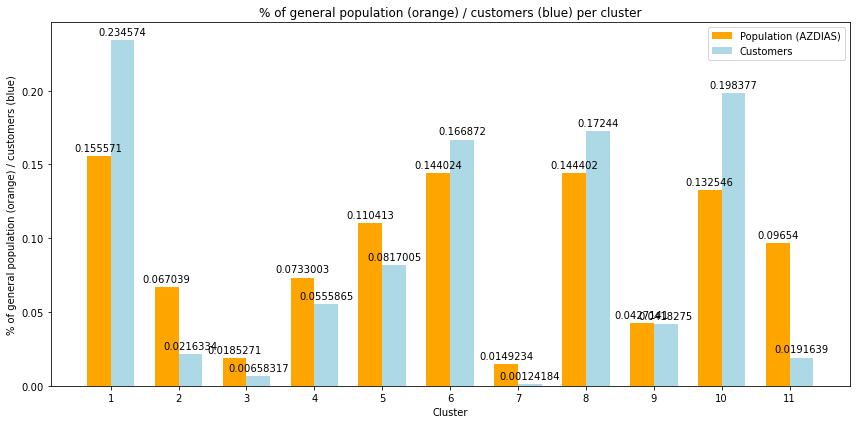

In [75]:
labels = list(clusters.cluster)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, clusters.population_share, width, label='Population (AZDIAS)', color='orange')
rects2 = ax.bar(x + width/2, clusters.customers_share, width, label='Customers', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of general population (orange) / customers (blue)')
ax.set_xlabel('Cluster')
ax.set_title('% of general population (orange) / customers (blue) per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Again, above plot visualized the distribution of general population and customers across all - now 11 - clusters. We also see that clusters 1 and 10 are strongly overrepresented in the customer base, indicating that it might me useful to target people from these clusters from the general population.

### 1 D: Meaning of clusters

Above I stated that the AZDIAS dataset can be clustered into 11 different clusters. But what does this mean exactly, and is there a "typical" representant of each cluster?

In [13]:
# Get the center of cluster 1-11
centroids = model.cluster_centers_
centroids

array([[ 6.64531343e-01, -1.88134042e+00,  2.93906864e+00, ...,
        -1.76277402e-02,  7.61338590e-03,  3.38702844e-03],
       [-2.68021701e-02, -1.20652807e+00,  7.61594178e-01, ...,
         1.25535298e-02, -1.42399140e-03,  3.78171557e-02],
       [ 3.11312186e+01,  8.23058271e+00,  3.93888181e+00, ...,
         6.05656890e-02,  7.63041074e-02,  7.24698467e-03],
       ...,
       [-1.63057252e+01, -3.50687618e+00, -2.08103769e-01, ...,
         3.07849990e-02,  3.18720686e-02,  3.30556480e-02],
       [ 5.23337588e-01,  3.65553061e-01, -2.79354240e+00, ...,
        -7.07635074e-03, -2.44312691e-02,  7.12478824e-03],
       [ 7.78005723e-01,  5.40918705e-02,  2.11477866e+00, ...,
        -1.18237426e-02,  5.58766033e-03, -7.45533854e-03]])

In [20]:
# Invert PCA
X_orig = np.dot(centroids, pca.components_)
# Invert scaling
X_orig_backscaled = pd.DataFrame(scaler.inverse_transform(X_orig), columns = azdias_cleaned.columns)

In [78]:
X_orig_backscaled['cluster_center'] = [1,2,3,4,5,6,7,8,9,10,11]
X_orig_backscaled.set_index('cluster_center').loc[[1,3,5,10],['OST_WEST_KZ','ANZ_HAUSHALTE_AKTIV','CAMEO_DEUG_2015','ONLINE_AFFINITAET','MOBI_REGIO','ALTERSKATEGORIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB','FINANZ_ANLEGER','FINANZ_MINIMALIST','HH_EINKOMMEN_SCORE']]

,OST_WEST_KZ,ANZ_HAUSHALTE_AKTIV,CAMEO_DEUG_2015,ONLINE_AFFINITAET,MOBI_REGIO,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_GROB,FINANZ_ANLEGER,FINANZ_MINIMALIST,HH_EINKOMMEN_SCORE
cluster_center,,,,,,,,,,,
1,0.969555,2.401220,3.942272,2.057802,4.121485,3.442991,5.022485,3.710073,2.161269,4.287713,3.549837
3,0.677673,24.986719,7.141942,1.479084,1.385971,3.051517,2.656649,1.491234,2.241709,2.498774,5.511765
5,0.771441,18.916868,7.876963,2.532215,1.457848,2.347442,2.882164,1.225567,3.073818,1.921398,5.572222
10,0.914349,12.928461,7.130319,1.614503,2.019251,3.477445,3.405567,1.459543,1.928190,2.864291,5.499779


Comparing above features for overrepresented clusters (1,10) to underrepresented clusters (3,5), we see the following saliences:

Overrepresented clusters
- tend to be more in western Germany
- tend to have above-average salary
- tend to be from smaller party households, probably due to higher salaries
- have high online affinity
- tend to have higher financial literacy (invest and safe)

Underrepresented clusters
- tend to earn less
- tend to be in many-party-households
- tend to be more in eastern Germany

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
# Save to pickle
mailout_train.to_pickle('mailout_train.pkl')

In [10]:
mailout_train = pd.read_pickle('mailout_train.pkl')

In [89]:
mailout_train_clean = clean_df(mailout_train, unknowns_map, azdias_not_in_attribute_list)

copy: (42962, 367)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4724\3890798865.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cleaned = df_cleaned.fillna(df_cleaned.median())


fill unknowns: (42962, 265)
map categories: (42962, 308)
map ost west: (42962, 308)
fill nans after merge: (42962, 308)
Before: (42962, 367)
After: (42962, 308) 

Datatypes:
float64    308
dtype: int64


In [90]:
responses_count = mailout_train_clean.RESPONSE.value_counts()
responses_count

0.0    42430
1.0      532
Name: RESPONSE, dtype: int64

<AxesSubplot:title={'center':'Distribution of responses in mailout_train_clean'}>

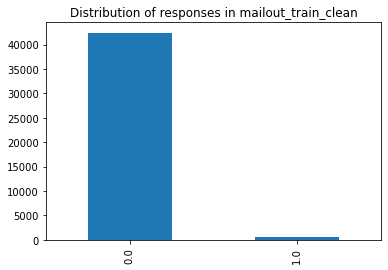

In [91]:
responses_count.plot(kind='bar', title="Distribution of responses in mailout_train_clean")

From above plot we see that the distribution of responses is highly unbalanced and skewed towards negative responses. In this context, many classification learning algorithms have low predictive accuracy for the infrequent class. This is called the **class imbalance problem**.

#### Dealing with class imbalance

I resample the set of positive responses in a way to obtain an equal number of positive and negative responses. By that, I hope to reduce the effect.

In [92]:
positives = mailout_train_clean[mailout_train_clean['RESPONSE']==1] 
negatives = mailout_train_clean[mailout_train_clean['RESPONSE']==0]

In [93]:
positives_balanced = resample(positives, replace=True, n_samples=len(negatives), random_state=42) 

In [94]:
# Combine balanced data sets of positive and negative responses
mailout_train_balanced = pd.concat([negatives, positives_balanced])

In [95]:
responses_count_balanced = mailout_train_balanced.RESPONSE.value_counts()
responses_count_balanced

0.0    42430
1.0    42430
Name: RESPONSE, dtype: int64

In [97]:
models = {'LogisticRegression': ,
          'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

In [96]:
X = mailout_train_balanced.drop(['RESPONSE'], axis=1)
y = mailout_train_balanced['RESPONSE']

In [109]:
# Scaling 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X))

#### Benchmark: Logistic regression

In [112]:
grid_lr = GridSearchCV(estimator=LogisticRegression(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y)

C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), param_grid={},
             scoring='roc_auc')

In [113]:
grid_lr.best_score_

0.7642492543901869

#### Random forest

In [115]:
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_rf.fit(X_train, y)
grid_rf.best_score_

0.9936156189432135

#### AdaBoost

In [116]:
grid_ab = GridSearchCV(estimator=AdaBoostClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_ab.fit(X_train, y)
grid_ab.best_score_

0.7234375563272643

#### Gradient boosting

In [117]:
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)
grid_gb.best_score_

0.9142034093780449

### Model tuning

In [118]:
params_gb = {'max_depth': range(4,9,2),
            'n_estimators': range(20,81,10)
            }

In [119]:
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid=params_gb, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)
grid_gb.best_score_

0.9925656093031797

In [126]:
joblib.dump(grid_gb, 'grid_gb.pkl')

['grid_gb.pkl']

In [127]:
clf = joblib.load('grid_gb.pkl')

In [129]:
clf.best_estimator_

GradientBoostingClassifier(max_depth=8, n_estimators=80, random_state=42)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
# Save as pickle
#mailout_test.to_pickle('mailout_test.pkl')

In [57]:
# Load pickle
mailout_test = pd.read_pickle('mailout_test.pkl')

In [58]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [100]:
mailout_test_clean = clean_df(mailout_test, unknowns_map, azdias_not_in_attribute_list)

copy: (42833, 366)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4724\3890798865.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cleaned = df_cleaned.fillna(df_cleaned.median())


fill unknowns: (42833, 264)
map categories: (42833, 307)
map ost west: (42833, 307)
fill nans after merge: (42833, 307)
Before: (42833, 366)
After: (42833, 307) 

Datatypes:
float64    307
dtype: int64


In [101]:
mailout_test_clean.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,2.0,7.0,2.0,0.0,2.0,0.0,3.0,6.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,20.0,0.0,1.0,0.0,4.0,7.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,16.0,2.0,0.0,4.0,0.0,4.0,1.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,21.0,1.0,0.0,4.0,0.0,3.0,6.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
# Scaling 
scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(mailout_test_clean), columns = mailout_test_clean.columns)

In [136]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,1.033789,-0.236176,-0.287584,-0.120872,-0.015838,-0.088595,-0.034350,0.937913,-0.595441,0.964749,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
1,-1.086712,-1.274215,1.038302,-0.120872,-0.819601,-0.088595,1.024156,1.291004,0.350607,-1.269686,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
2,1.033789,1.098445,-0.287584,-0.120872,1.591688,-0.088595,1.024156,-0.827542,0.981306,-0.711078,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
3,-1.086712,-1.274215,-0.361244,-0.120872,-1.623364,-0.088595,1.024156,-0.827542,-0.595441,0.406140,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
4,0.326956,1.839902,-0.361244,-0.120872,1.591688,-0.088595,-0.034350,0.937913,0.350607,1.523357,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894


In [139]:
predictions = grid_gb.predict(X_test)
predictions

C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


array([0., 0., 0., ..., 0., 0., 0.])

In [140]:
predictions.sum()

1146.0

In [141]:
# Create CSV for Kaggle submission
kaggle = pd.DataFrame({'LNR':mailout_test['LNR'].astype(np.int32), 'RESPONSE':predictions})
kaggle.to_csv('kaggle.csv', index=False)